In [1]:
from datetime import datetime
from multiprocessing import Pool

import time
import os
import sys
from pathlib import Path

import numpy as np
import scipy
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import astropy.units as u
from astropy.io import fits
from mmtwfs.wfs import WFSFactory

In [2]:
# instantiate all of the WFS systems...
wfs_keys = ['newf9', 'f9', 'f5', 'mmirs']
wfs_systems = {}
wfs_names = {}
for w in wfs_keys:
    wfs_systems[w] = WFSFactory(wfs=w)
    wfs_names[w] = wfs_systems[w].name
plt.close('all')

In [3]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def check_wfs(p):
    """
    Check to see which system was used on a given night
    """
    if Path.exists(p / "F9"):  # wow, i really like pathlib.Path...
        return "f9"
    elif Path.exists(p / "F5"):
        return "f5"
    elif Path.exists(p / "MMIRS"):
        return 'mmirs'
    else:
        return None

def process_image(f):
    """
    Process FITS file, f, to get info we want from the header and then analyse it with the 
    appropriate WFS instance. Return results in a comma-separated line that will be collected 
    and saved in a CSV file.
    """
    try:
        if "ave" not in f.name:
            with fits.open(f) as h:
                hdr = h[0].header
                if 'AIRMASS' in hdr:
                    airmass = hdr['AIRMASS']
                else:
                    airmass = np.nan
                # we need to fix the headers in all cases to have a proper DATE-OBS entry with
                # properly formatted FITS timestamp.  in the meantime, this hack gets us what we need 
                # for analysis in pandas.
                if 'DATEOBS' not in hdr:
                    return None
                dateobs = hdr['DATEOBS']
                ut = hdr['ut']
                timestring = dateobs + " " + ut + " UTC"
                dtime = datetime.strptime(timestring , "%a %b %d %Y %H:%M:%S %Z")
                obstime = dtime.isoformat()
                # being conservative here and only using data that has proper slope determination
                # and wavefront solution. also want to get statistics on the quality of the wavefront fits.
                results = wfs_systems[wfskey].measure_slopes(f, plot=False)
                if results['slopes'] is not None:
                    zresults = wfs_systems[wfskey].fit_wavefront(results, plot=False)
                    line = "%s,%s,%s,%f,%f,%f,%f,%f\n" % (
                        obstime,
                        wfskey,
                        f.name, 
                        airmass,
                        results['seeing'].value,
                        results['raw_seeing'].value,
                        results['fwhm'],
                        zresults['residual_rms'].value
                    )
                    zfile = f.parent / (f.stem + ".zernike")
                    zresults['zernike'].save(filename=zfile)
                    return line
                else:
                    return None
        return None
    except Exception as e:
        print("whoops at %s! %s" % (f.name, e))
        return None

In [ ]:
#rootdir = Path("/Users/tim/MMT/wfsdat/test")
rootdir = Path("/Volumes/LaCie/wfsdat")
dirs = rootdir.glob("*")  # pathlib, where have you been all my life!
csv_header = "time,wfs,file,airmass,seeing,raw seeing,fwhm,wavefront rms\n"
for d in dirs:
    if d.is_dir():
        if Path.exists(d / "seeing_results.csv"):
            print("Already processed %s..." % d.name)
        else:
            try:
                lines = []
                lines.append(csv_header)
                night = int(d.name)  # valid WFS directories are ints of the form YYYYMMDD. if not this form, int barfs
                msg = "checking %d... " % night
                wfskey = check_wfs(d)
                if wfskey is not None:
                    if wfskey == "mmirs":
                        rawd = d / "rawdata"
                        fitsfiles = rawd.glob("*.fits")
                    else:
                        fitsfiles = d.glob("*.fits")
                    if wfskey == "f9" and night > 20170510:
                        wfskey = "newf9"
                    msg += " using %s." % wfskey
                    print(msg)
                    with Pool(processes=8) as pool:  # my mac's i7 has 4 cores + hyperthreading so 8 virtual cores. 
                        plines = pool.map(process_image, fitsfiles)  # plines comes out in same order as fitslines!
                    plines = list(filter(None.__ne__, plines))  # trim out any None entries
                    lines.extend(plines)
                    with open(d / "seeing_results.csv", "w") as f:
                        f.writelines(lines)
                else:
                    msg = "No valid wfskey for %s..." % d
                    print(msg)
            except ValueError:  # this means running int(d.name) failed so it's not a valid directory...
                print("Skipping %s..." % d.name)

In [4]:
# use find to make this csv list
with open("csvs2017.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [5]:
# create a date-time index so we can group and analyze the data by timestamps
timedata = data.set_index(pd.DatetimeIndex(data['time'], name='ut'))
trimdata = timedata[(timedata['seeing'] > 0.1) & (timedata['seeing'] < 3.0)]
trimdata = trimdata.drop('time', axis=1)
# had some reference images sneak into analysis. ignore them. also ignore data above 3" since WFS can't measure it.

<IPython.core.display.Javascript object>


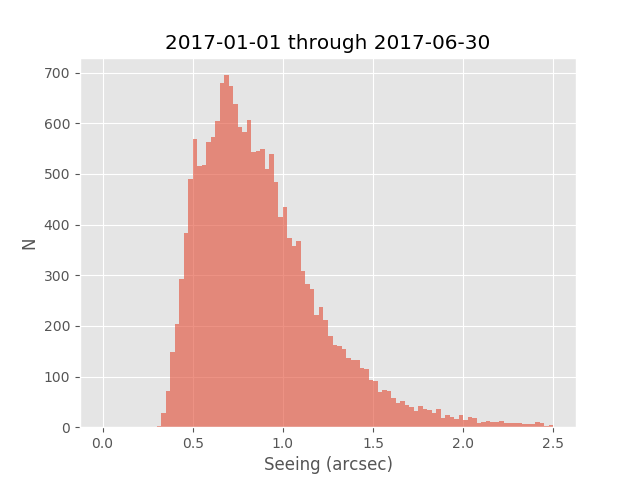

In [6]:
# make raw histogram of the zenith-corrected seeing column
trimdata.hist(column='seeing', bins=100, range=(0.0, 2.5), alpha=0.6)
plt.title("2017-01-01 through 2017-06-30")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
plt.show()

In [7]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = scipy.stats.lognorm.fit(trimdata['seeing'])
x = np.arange(0.0, 2.5, 0.01)
p = scipy.stats.lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.median(trimdata['seeing'])
fit_median = exp_mu + loc

<IPython.core.display.Javascript object>


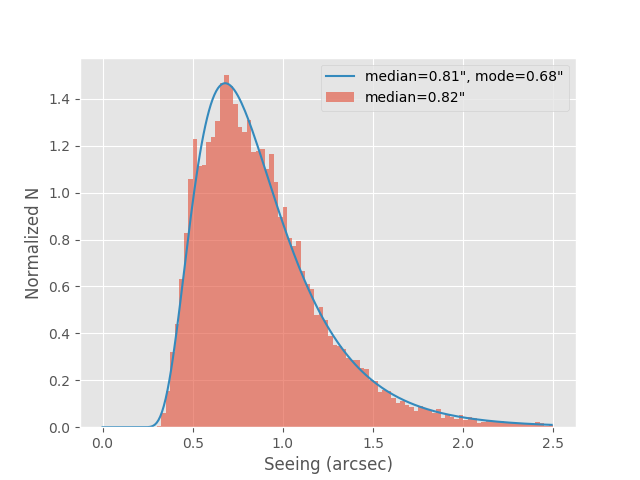

In [8]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
plt.hist(trimdata['seeing'], normed=True, bins=100, range=(0.0, 2.5), label="hist", alpha=0.6)
logp = plt.plot(x, p, label="logp")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("Normalized N")
plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
    median
)])
plt.show()

<IPython.core.display.Javascript object>


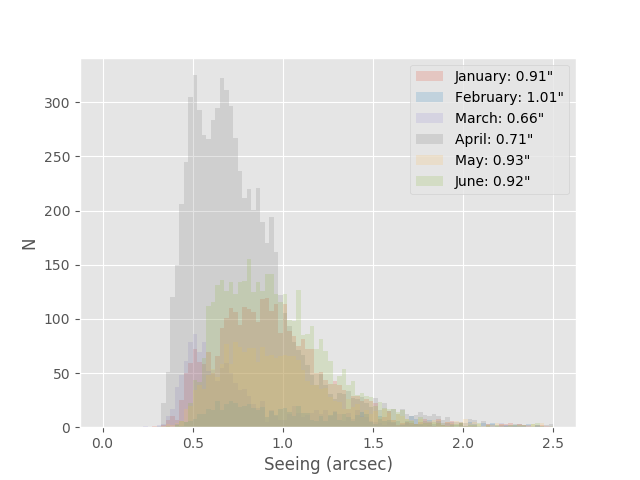

In [18]:
# panda time indexing makes it easy to group by month
months = {}
legends = []
months['January'] = trimdata['2017-01']
months['February'] = trimdata['2017-02']
months['March'] = trimdata['2017-03']
months['April'] = trimdata['2017-04']
months['May'] = trimdata['2017-05']
months['June'] = trimdata['2017-06']
for m in months:
    plt.hist(months[m]['seeing'], bins=100, range=(0.0, 2.5), label=m, alpha=0.2)
    legend = "%s: %.2f\"" % (m, np.median(months[m]['seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.show()

In [12]:
# almost half the total amount of data was from MMIRS in april...
len(trimdata)

18599

In [13]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = trimdata.between_time(start_time='00:00', end_time='07:00')
second_half = trimdata.between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

In [16]:
# now use the between_time() method to split the data into quadrants of the night.
first_q = trimdata.between_time(start_time='01:00', end_time='04:00')
second_q = trimdata.between_time(start_time='04:00', end_time='07:00')
third_q = trimdata.between_time(start_time='07:00', end_time='10:00')
fourth_q = trimdata.between_time(start_time='10:00', end_time='13:00')
med_1q = np.median(first_q['seeing'])
med_2q = np.median(second_q['seeing'])
med_3q = np.median(third_q['seeing'])
med_4q = np.median(fourth_q['seeing'])

<IPython.core.display.Javascript object>


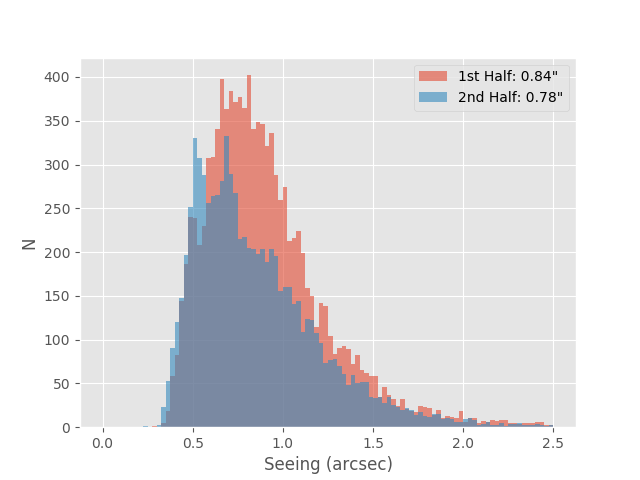

In [14]:
# plot the results and show that the seeing is better later in the night...
plt.hist(first_half['seeing'], bins=100, range=(0.0, 2.5), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 2.5), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.show()

<IPython.core.display.Javascript object>


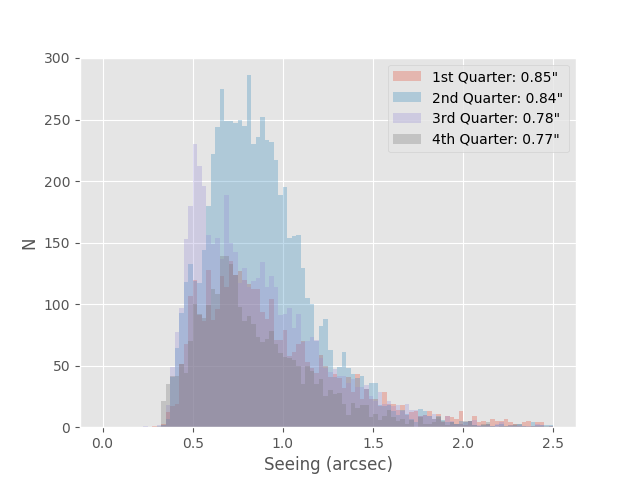

In [19]:
plt.hist(first_q['seeing'], bins=100, range=(0.0, 2.5), label="1st Q", alpha=0.3)
plt.hist(second_q['seeing'], bins=100, range=(0.0, 2.5), label="2nd Q", alpha=0.3)
plt.hist(third_q['seeing'], bins=100, range=(0.0, 2.5), label="3rd Q", alpha=0.3)
plt.hist(fourth_q['seeing'], bins=100, range=(0.0, 2.5), label="4th Q", alpha=0.3)
plt.legend([
    "1st Quarter: %.2f\"" % med_1q, 
    "2nd Quarter: %.2f\"" % med_2q,
    "3rd Quarter: %.2f\"" % med_3q,
    "4th Quarter: %.2f\"" % med_4q
])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.show()

<IPython.core.display.Javascript object>


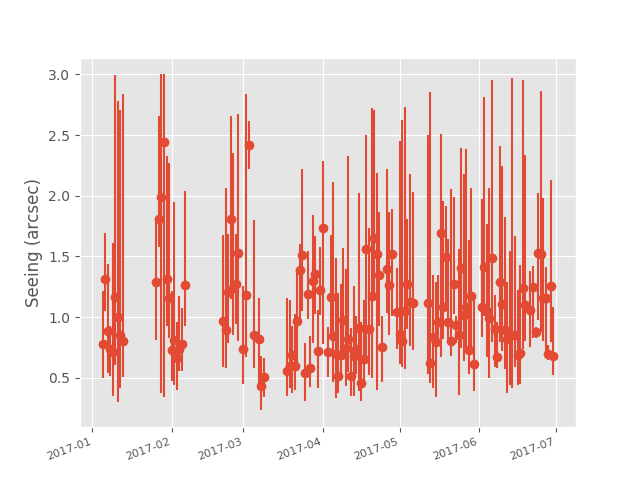

In [15]:
# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = trimdata.seeing.resample('D').median()
daily['max'] = trimdata.seeing.resample('D').max()
daily['min'] = trimdata.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
labels = ax.get_xticklabels()
plt.setp(labels, rotation=20, fontsize=8, ha='right')
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.show()